In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split

In [2]:

# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
image_path='./image'
sketch_path='./sketch'

In [4]:
def convert_rgba_to_rgb(image):
    # Separate the RGB and Alpha channels
    rgb_image = image[..., :3]
    alpha_channel = image[..., 3]

    # Normalize the RGB values to [0, 1]
    # rgb_image = rgb_image / 255.0

    # Check if the pixel is white: RGB == [255, 255, 255]
    # Since rgb_image is normalized to [0, 1], compare it to 1
    is_rgb_white = tf.reduce_all(tf.equal(rgb_image, 255), axis=-1)

    # Check if alpha is 0 (fully transparent)
    is_alpha_zero = tf.equal(alpha_channel, 0)

    # A pixel should be white if it is fully transparent or its RGB value is [255, 255, 255]
    is_white = tf.logical_or(is_rgb_white, is_alpha_zero)

    # Create a white image where all white pixels are true
    white_image = tf.ones_like(rgb_image)*255

    # Create the RGB image by setting white pixels in the RGB image
    rgb_image = tf.where(is_white[..., tf.newaxis], white_image, rgb_image)

    # Convert the image back to [0, 255] range for RGB image
    # rgb_image = rgb_image * 255.0

    return tf.cast(rgb_image, tf.float32)

In [5]:
def get_file_list(directory):
    # List all files in the directory
    file_list = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return file_list

In [6]:
def split_train_test(file_list, test_size=0.2, random_state=42):
    # Split the file list into train and test sets
    train_files, test_files = train_test_split(file_list, test_size=test_size, random_state=random_state)
    return train_files, test_files

In [7]:
list_of_image = get_file_list(image_path)
train_files, test_files = split_train_test(list_of_image)

In [8]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [9]:
def resize(image, sketch, height, width):
  image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  sketch = tf.image.resize(sketch, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return image,sketch

In [10]:
def load_and_preprocess_image(image_name):
    """Load an image and apply preprocessing."""
    # Assuming image_path and sketch_path are global variables
    # Concatenate paths using TensorFlow operations
    image_path_full = tf.strings.join([image_path, image_name], separator='/')
    sketch_path_full = tf.strings.join([sketch_path, image_name], separator='/')

    # Read and decode the image
    image = tf.io.read_file(image_path_full)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)

    # Read and decode the sketch
    sketch = tf.io.read_file(sketch_path_full)
    sketch = tf.io.decode_jpeg(sketch, channels=4)
    sketch=convert_rgba_to_rgb(sketch)
    sketch = tf.cast(sketch, tf.float32)

    # Resize the image and sketch
    image, sketch = resize(image, sketch, 128, 128)
    # image, sketch = normalize(image,sketch)
    # print(sketch.shape)

    # # Normalize the image and sketch
    sketch = sketch / 255.0
    image = image / 255.0
    # print(sketch)
    return image, sketch


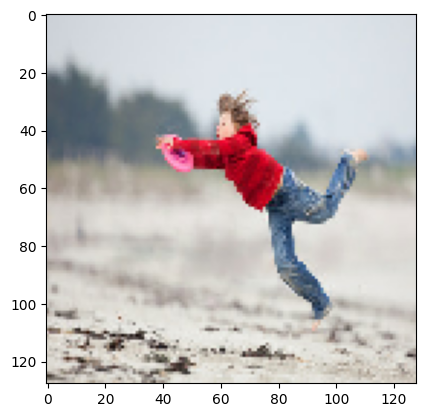

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


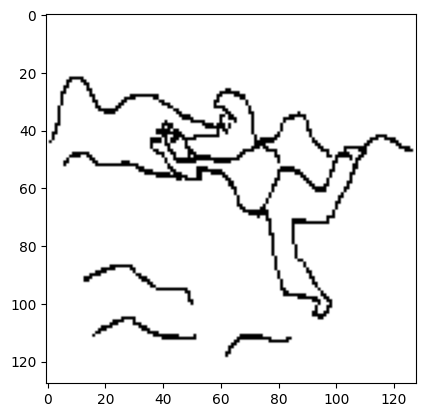

In [11]:
im,sk=load_and_preprocess_image("00000005.jpg")
plt.imshow(im)
plt.show()
plt.imshow(sk*255)
# print(sk)


In [12]:
# The facade training set consist of 400 images
BUFFER_SIZE = 800
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_and_preprocess_image,
                                  num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_and_preprocess_image,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [17]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(im, 0))
print (down_result.shape)

(1, 64, 64, 3)


In [18]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [19]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [22]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  down_stack = [
    downsample(32, 4, apply_batchnorm=False),
    downsample(64, 4),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4), # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 1,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 2, 2, 512), (None, 1, 1, 512)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7991803..5.6386466].


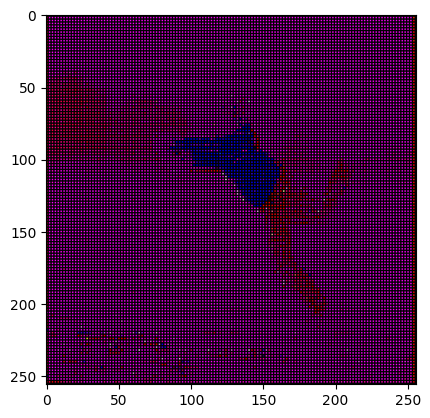

In [22]:
gen_output = generator(im[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...]*255)

In [23]:
LAMBDA = 100

In [24]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [26]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [27]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

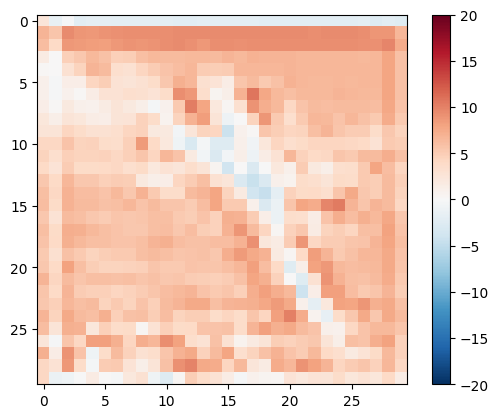

In [28]:
disc_out = discriminator([im[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1]*255, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']


  plt.subplot(1, 3, 1)
  plt.title(title[0])
  # Getting the pixel values in the [0, 1] range to plot.
  plt.imshow(display_list[0])
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title(title[1])
  # Getting the pixel values in the [0, 1] range to plot.
  plt.imshow(display_list[1]*255)
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title(title[2])
  # Getting the pixel values in the [0, 1] range to plot.
  plt.imshow(display_list[2]*255)
  plt.axis('off')
  plt.show()

In [33]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [34]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [35]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [36]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000== 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 500 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [37]:
print(test_dataset.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-145.18822..144.58795].


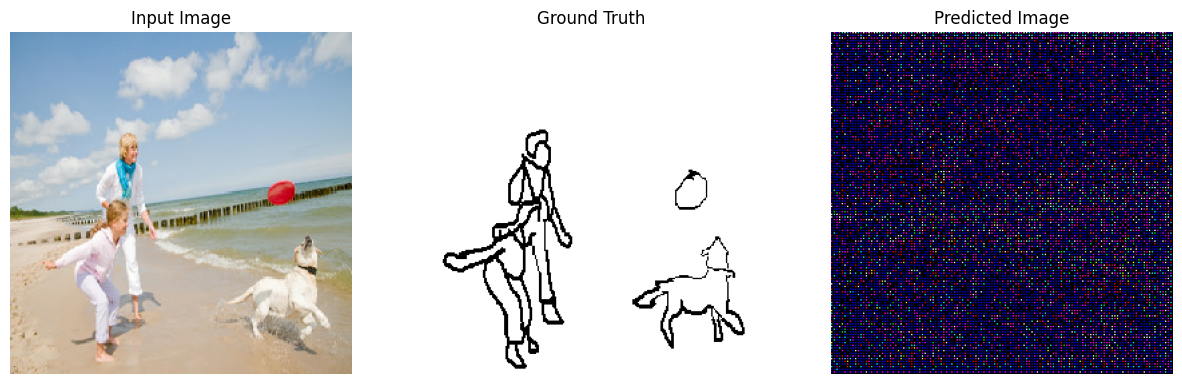

: 

In [38]:
for example_input, example_target in train_dataset.take(1):
    generate_images(generator, example_input, example_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-133.21466..122.08982].


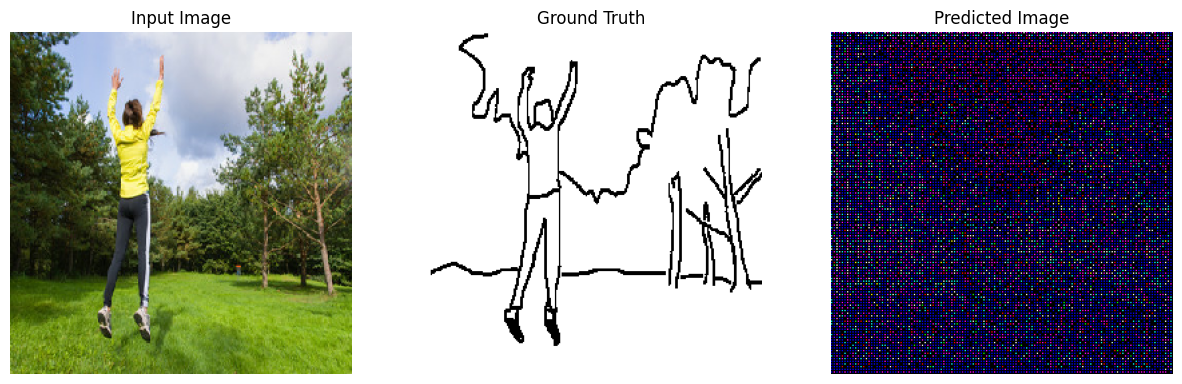

Step: 0k


In [39]:
fit(train_dataset, test_dataset, steps=40000)